# Personalized Medicine: Redefining Cancer Treatment
### Predict the effect of Genetic Variants to enable Personalized Medicine
##### https://www.kaggle.com/c/msk-redefining-cancer-treatment
- 임상 결과를 바탕으로 암의 돌연변이를 일으키는 유전적 요인을 분석하는 프로젝트

In [6]:
import numpy as np # Linear Algebra
import pandas as pd # Data Processing
import matplotlib.pyplot as plt # Visualize
import seaborn as sns # Visualize
%matplotlib inline

# Data Import

In [7]:
train_text_df = pd.read_csv('data/training_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv('data/test_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
train_vari_df = pd.read_csv('data/training_variants')
test_vari_df = pd.read_csv('data/test_variants')

In [26]:
train_vari_df.tail()

,ID,Gene,Variation,Class
3316,3316,RUNX1,D171N,4
3317,3317,RUNX1,A122*,1
3318,3318,RUNX1,Fusions,1
3319,3319,RUNX1,R80C,4
3320,3320,RUNX1,K83E,4


In [27]:
train_text_df.tail()

,ID,Text
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,The most frequent mutations associated with le...


##### 데이터의 구성
- variation과 text set은 ID를 통해 연결되어 있다
- Gene: 돌연변이가 발생한 유전자
- Variation: 해당 돌연변이에 대한 아미노산 변화
- Class: 돌연변이의 분류(1~9 Class)
- Text: 돌연변이 분류의 근거가 되는 임상 기록
  
##### 분석의 목표
- Gene, Variation, Text를 통해 Class를 분류하는 것
- Class의 분류는 임상 결과인 Text를 기반으로 이뤄졌다고 한다
- 따라서 TF-IDF 등 text 분석 기법을 통해 Class를 분류할 필요가 있다고 판단됨

# EDA

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

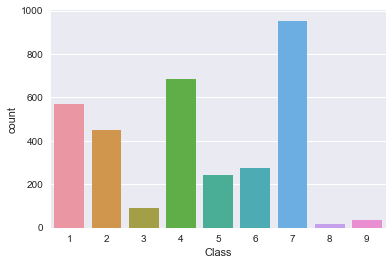

In [30]:
sns.countplot(x="Class", data=train_vari_df)
train_vari_df.Class.value_counts()

In [24]:
train_vari_df.Gene.value_counts()

BRCA1      264
TP53       163
EGFR       141
PTEN       126
BRCA2      125
KIT         99
BRAF        93
ALK         69
ERBB2       69
PDGFRA      60
PIK3CA      56
CDKN2A      52
FGFR2       50
FLT3        49
TSC2        47
MTOR        45
KRAS        44
MAP2K1      43
VHL         41
RET         40
FGFR3       39
MLH1        35
SMAD4       33
JAK2        33
MET         33
NOTCH1      31
AKT1        28
ABL1        26
PTPN11      26
ROS1        26
          ... 
PAK1         1
IKBKE        1
AURKB        1
KMT2B        1
FOXO1        1
CEBPA        1
WHSC1L1      1
FGF3         1
AXIN1        1
HLA-B        1
RRAS2        1
GNA11        1
WHSC1        1
ERRFI1       1
RAD51B       1
BARD1        1
MDM4         1
EPCAM        1
RAD54L       1
FGF19        1
VEGFA        1
ATR          1
FAM58A       1
RARA         1
GNAQ         1
ASXL1        1
RYBP         1
SHQ1         1
SRSF2        1
FANCC        1
Name: Gene, Length: 264, dtype: int64

In [25]:
train_vari_df.Variation.value_counts()

Truncating Mutations            93
Deletion                        74
Amplification                   71
Fusions                         34
Overexpression                   6
G12V                             4
E17K                             3
T58I                             3
Q61L                             3
Q61H                             3
Q61R                             3
G12D                             2
G13V                             2
E542K                            2
F384L                            2
R173C                            2
ETV6-NTRK3 Fusion                2
T167A                            2
G12A                             2
M1R                              2
A146T                            2
T286A                            2
Promoter Hypermethylation        2
K117N                            2
P34R                             2
S308A                            2
A146V                            2
EWSR1-ETV1 Fusion                2
T73I                

In [15]:
print(train_text_df.iloc[0,1])

Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10